# Final Project
## Rijul Nanda, Youchan Lee


##### In this project, we will analyze different images of the eye to detect eye diseases. The original dataset was taken from here: 
##### https://www.kaggle.com/andrewmvd/ocular-disease-recognition-odir5k
##### Additional data for glaucoma: https://www.kaggle.com/sshikamaru/glaucoma-detection/version/2
##### Additional data for diabetic retinopathy: https://www.kaggle.com/c/diabetic-retinopathy-detection/data
##### Additional data for hypertension: https://retinagallery.com/thumbnails.php?album=731


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import collections
import pandas as pd
import skimage.io
import scipy.io
import math
import cv2
from PIL import Image, ImageOps

import os
from os import path
import shutil

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from random import sample
import seaborn as sns
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.utils import plot_model
from scikitplot.metrics import plot_confusion_matrix as plt_con_mat

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import tensorflow_addons as tfa
import pathlib
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras
import random

In [2]:
# Read the csv describing the images
df = pd.read_csv('ocular_disease_fundus/full_df.csv')
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [3]:
xl = pd.read_excel('ocular_disease_fundus/ODIR-5K/ODIR-5K/data.xlsx')
xl

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


In [4]:
diseases = list(xl.columns[7:15])
xl['Labels'] = xl.apply(lambda x:[disease for disease in diseases if x[disease]==1], axis=1)
xl

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,Labels
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,[C]
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,[N]
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,"[D, O]"
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,[O]
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,"[D, O]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,[D]
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,[D]
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,[D]
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,[D]


Now, let's look at an example image just to see what they all look like, and to ensure we can open images in python.

In [5]:
# Split up the left and right eye information

cols = ['Image', 'Keywords', 'Age', 'Sex', 'Labels']

left = xl[['Left-Fundus', 'Left-Diagnostic Keywords', 'Patient Age', 'Patient Sex', 'Labels']]
left.columns = cols

right = xl[['Right-Fundus', 'Right-Diagnostic Keywords', 'Patient Age', 'Patient Sex', 'Labels']]
right.columns = cols

# combine them back
both_eyes = pd.concat([left, right], axis=0)

both_eyes

,Image,Keywords,Age,Sex,Labels
0,0_left.jpg,cataract,69,Female,[C]
1,1_left.jpg,normal fundus,57,Male,[N]
2,2_left.jpg,laser spot，moderate non proliferative retinopathy,42,Male,"[D, O]"
3,3_left.jpg,normal fundus,66,Male,[O]
4,4_left.jpg,macular epiretinal membrane,53,Male,"[D, O]"
...,...,...,...,...,...
3495,4686_right.jpg,proliferative diabetic retinopathy,63,Male,[D]
3496,4688_right.jpg,moderate non proliferative retinopathy,42,Male,[D]
3497,4689_right.jpg,normal fundus,54,Male,[D]
3498,4690_right.jpg,mild nonproliferative retinopathy,57,Male,[D]


### Start with the basic 7 diseases.

In [6]:
def cataract(diagnostic_keyword):
    if "cataract" in diagnostic_keyword:
        return 1
    else:
        return 0
    
def normal(diagnostic_keyword):
    if "normal" in diagnostic_keyword:
        return 1
    else:
        return 0
    
def diabetes(diagnostic_keyword):
    if "proliferative retinopathy" in diagnostic_keyword or 'diabetic' in diagnostic_keyword:
        return 1
    else:
        return 0
    
def glaucoma(diagnostic_keyword):
    if "glaucoma" in diagnostic_keyword:
        return 1
    else:
        return 0
    
def amd(diagnostic_keyword):
    if "age-related" in diagnostic_keyword:
        return 1
    else:
        return 0

def hypertension(diagnostic_keyword):
    if "hypertens" in diagnostic_keyword:
        return 1
    else:
        return 0

def myopia(diagnostic_keyword):
    if "myopia" in diagnostic_keyword:
        return 1
    else:
        return 0

In [7]:
xl["left_cataract"] = xl["Left-Diagnostic Keywords"].apply(lambda word: cataract(word))
xl["right_cataract"] = xl["Right-Diagnostic Keywords"].apply(lambda word: cataract(word))

xl["left_normal"] = xl["Left-Diagnostic Keywords"].apply(lambda word: normal(word))
xl["right_normal"] = xl["Right-Diagnostic Keywords"].apply(lambda word: normal(word))

xl["left_diabetes"] = xl["Left-Diagnostic Keywords"].apply(lambda word: diabetes(word))
xl["right_diabetes"] = xl["Right-Diagnostic Keywords"].apply(lambda word: diabetes(word))

xl["left_glaucoma"] = xl["Left-Diagnostic Keywords"].apply(lambda word: glaucoma(word))
xl["right_glaucoma"] = xl["Right-Diagnostic Keywords"].apply(lambda word: glaucoma(word))

xl["left_amd"] = xl["Left-Diagnostic Keywords"].apply(lambda word: amd(word))
xl["right_amd"] = xl["Right-Diagnostic Keywords"].apply(lambda word: amd(word))

xl["left_hypertension"] = xl["Left-Diagnostic Keywords"].apply(lambda word: hypertension(word))
xl["right_hypertension"] = xl["Right-Diagnostic Keywords"].apply(lambda word: hypertension(word))

xl["left_myopia"] = xl["Left-Diagnostic Keywords"].apply(lambda word: myopia(word))
xl["right_myopia"] = xl["Right-Diagnostic Keywords"].apply(lambda word: myopia(word))

xl

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,left_diabetes,right_diabetes,left_glaucoma,right_glaucoma,left_amd,right_amd,left_hypertension,right_hypertension,left_myopia,right_myopia
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,1,1,0,0,0,0,0,0,0,0
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,...,1,1,0,0,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,1,1,0,0,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,...,1,1,0,0,0,0,0,0,0,0


In [8]:
# get all images that have cataracts
left_cataract = xl.loc[(xl.left_cataract == 1) & (xl.C == 1)]['Left-Fundus'].values
right_cataract = xl.loc[(xl.right_cataract == 1) & (xl.C == 1)]['Right-Fundus'].values

# get all images that have normal
left_normal = xl.loc[(xl.left_normal == 1) & (xl.N == 1)]['Left-Fundus'].values
right_normal = xl.loc[(xl.right_normal == 1) & (xl.N == 1)]['Right-Fundus'].values

# get all images that have diabetes
left_diabetes = xl.loc[(xl.left_diabetes == 1) & (xl.D == 1)]['Left-Fundus'].values
right_diabetes = xl.loc[(xl.right_diabetes == 1) & (xl.D == 1)]['Right-Fundus'].values

# get all images that have glaucoma
left_glaucoma = xl.loc[(xl.left_glaucoma == 1) & (xl.G == 1)]['Left-Fundus'].values
right_glaucoma = xl.loc[(xl.right_glaucoma == 1) & (xl.G == 1)]['Right-Fundus'].values

# get all images that have AMD
left_amd = xl.loc[(xl.left_amd == 1) & (xl.A == 1)]['Left-Fundus'].values
right_amd = xl.loc[(xl.right_amd == 1) & (xl.A == 1)]['Right-Fundus'].values

# get all images that have hypertension
left_hyper = xl.loc[(xl.left_hypertension == 1) & (xl.H == 1)]['Left-Fundus'].values
right_hyper = xl.loc[(xl.right_hypertension == 1) & (xl.H == 1)]['Right-Fundus'].values

# get all images that have myopia
left_myopia = xl.loc[(xl.left_myopia == 1) & (xl.M == 1)]['Left-Fundus'].values
right_myopia = xl.loc[(xl.right_myopia == 1) & (xl.M == 1)]['Right-Fundus'].values

In [9]:
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)
diabetes = np.concatenate((left_diabetes, right_diabetes), axis=0)
glaucoma = np.concatenate((left_glaucoma, right_glaucoma), axis=0)
amd = np.concatenate((left_amd, right_amd), axis=0)
hyper = np.concatenate((left_hyper, right_hyper), axis=0)
myopia = np.concatenate((left_myopia, right_myopia), axis=0)

In [10]:
# how many images total that are other?
print(7000 - (len(diabetes) + len(cataract) + len(normal) + len(glaucoma) + len(amd) + len(hyper) + len(myopia)))

1551


In [12]:
# Create folders with all of the images classified into them - training images
src = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images"
dst_D = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/diabetes"
dst_N = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/normal"
dst_G = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/glaucoma"
dst_A = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/amd"
dst_H = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/hypertension"
dst_M = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/myopia"
dst_C = "ocular_disease_fundus/ODIR-5K/ODIR-5K/ALL Training Images/cataracts"

for f in cataract:
    shutil.copy(path.join(src, f), dst_C)

for f in diabetes:
    shutil.copy(path.join(src, f), dst_D)

for f in normal:
    shutil.copy(path.join(src, f), dst_N)

for f in glaucoma:
    shutil.copy(path.join(src, f), dst_G)

for f in amd:
    shutil.copy(path.join(src, f), dst_A)
    
for f in hyper:
    shutil.copy(path.join(src, f), dst_H)

for f in myopia:
    shutil.copy(path.join(src, f), dst_M)

#### Model 1: Multiclass ResNet50

In [155]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 25
IMG_DIR = pathlib.Path('ocular_disease_fundus/preprocessed_images')
TRAIN_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/Actual Training Images'
VAL_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/Actual Testing Images'

In [156]:
# Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [157]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

Found 3340 images belonging to 7 classes.
Found 2291 images belonging to 7 classes.


In [65]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

94773248/94765736 [==============================] - 6s 0us/step


In [ ]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [88]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 7

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 7175      
Total params: 26,742,663
Trainable params: 26,689,543
Non-trainable params: 53,120
_____________________________________

In [89]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,
                                              restore_best_weights=False
                                              )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )

In [90]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [205]:
model.fit(train_generator,
          steps_per_epoch=np.ceil(float(3340) / float(BATCH_SIZE)),
          epochs = 35,callbacks=[early_stop,reduce_lr],
          validation_steps=np.ceil(float(2291) / float(BATCH_SIZE)),
          validation_data = validation_generator)

#### Model 2: AlexNet Multiclass Attempt

In [45]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 25
IMG_DIR = pathlib.Path('ocular_disease_fundus/preprocessed_images')
TRAIN_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/Actual Training Images'
VAL_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/Actual Testing Images'

In [46]:
np.random.seed(1000)
AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Flatten())

AlexNet.add(Dense(64, input_shape=(224,224,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(64))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))

AlexNet.add(Dense(7))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

AlexNet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_8 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
activation_8 (Activation)    (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 256)      

In [47]:
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy', 'Precision', 'Recall'])

In [48]:
# Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [49]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

Found 3340 images belonging to 7 classes.
Found 2291 images belonging to 7 classes.


In [50]:
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(monitor='val_acc',   factor=.01,   patience=3,  min_lr=1e-5) 

In [51]:
batch_size= 100
epochs=20
learn_rate=.001

In [26]:
AlexNet.fit_generator(train_generator, epochs = epochs, steps_per_epoch = np.ceil(float(3340) / float(BATCH_SIZE)), 
validation_data = validation_generator, validation_steps = np.ceil(float(2291) / float(BATCH_SIZE)), callbacks = [lrr], verbose=1)

Epoch 1/20
134/134 [==============================] - 535s 4s/step - loss: 2.0600 - accuracy: 0.2326 - precision: 0.2687 - recall: 0.0269 - val_loss: 4.5396 - val_accuracy: 0.1017 - val_precision: 0.0418 - val_recall: 0.0262
Epoch 2/20
134/134 [==============================] - 490s 4s/step - loss: 1.8724 - accuracy: 0.3123 - precision: 0.3503 - recall: 0.0207 - val_loss: 2.2200 - val_accuracy: 0.2213 - val_precision: 0.1166 - val_recall: 0.0113
Epoch 3/20
134/134 [==============================] - 486s 4s/step - loss: 1.7449 - accuracy: 0.3341 - precision: 0.4231 - recall: 0.0165 - val_loss: 1.7365 - val_accuracy: 0.3536 - val_precision: 0.2453 - val_recall: 0.0057
Epoch 4/20
134/134 [==============================] - 493s 4s/step - loss: 1.6681 - accuracy: 0.3734 - precision: 0.4898 - recall: 0.0144 - val_loss: 1.7082 - val_accuracy: 0.3828 - val_precision: 0.2171 - val_recall: 0.0122
Epoch 5/20
134/134 [==============================] - 504s 4s/step - loss: 1.5978 - accuracy: 0.4024

In [54]:
y_pred = AlexNet.predict_classes(validation_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

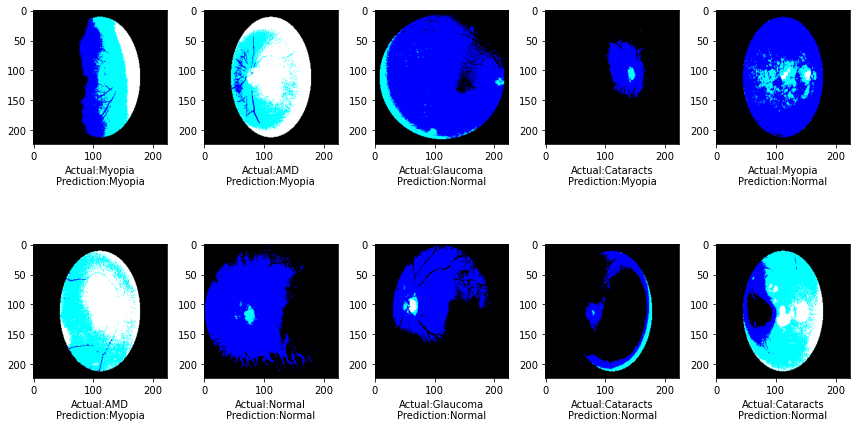

In [77]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(validation_generator)))
    image = validation_generator[samp][0][0]
    category = y_test[samp]
    pred_category = y_pred[samp]
    if category == 0:
        label = "AMD"
    elif category == 1:
        label = "Cataracts"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Normal"
    if pred_category == 0:
        pred_label = "AMD"
    elif pred_category == 1:
        pred_label = "Cataracts"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Normal"

    plt.subplot(2,5,i+1)
    plt.imshow(image, cmap = "gray")
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

## MODEL 0: Individual Diabetes Model

In [22]:
path = "ocular_disease_fundus/"
df = pd.read_csv(path + "full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [23]:
file_names_diabetes = []
labels_diabetes = []

In [24]:
for text, label, file_name in zip(df["Left-Diagnostic Keywords"], df["D"], df["Left-Fundus"]):
    
    if(("proliferative retinopathy" in text) and (label == 1)):
        file_names_diabetes.append(file_name)
        labels_diabetes.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_diabetes.append(file_name)
        labels_diabetes.append(0)

In [25]:
for text, label, file_name in zip(df["Right-Diagnostic Keywords"], df["D"], df["Right-Fundus"]):
    
    if(("proliferative retinopathy" in text) and (label == 1)):
        file_names_diabetes.append(file_name)
        labels_diabetes.append(1)
    
    elif(("normal fundus" in text) and (label == 0)):
        file_names_diabetes.append(file_name)
        labels_diabetes.append(0)

In [26]:
ROW = 224
COL = 224

image_data_diabetes = []
for idx, image_name in enumerate(file_names_diabetes):
    
    img = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        img = cv2.resize(img, (ROW, COL))
        image_data_diabetes.append(img)
    except:
        del labels_diabetes[idx]
    
image_data_diabetes = np.array(image_data_diabetes)

In [27]:
from keras.utils.np_utils import to_categorical

temp = []
for idx, label in enumerate(labels_diabetes):
    if label == 0:
        temp.append(idx)

temp = sample(temp, len([label for label in labels_diabetes if label == 1]))

X_data = []
y_data = []

for idx in temp:
    X_data.append(image_data_diabetes[idx])
    y_data.append(labels_diabetes[idx])

temp = []
for idx, label in enumerate(labels_diabetes):
    if label == 1:
        temp.append(idx)
        
for idx in temp:
    X_data.append(image_data_diabetes[idx])
    y_data.append(labels_diabetes[idx])

X_data = np.array(X_data)
    
y_data = np.array(y_data)
y_data = np.expand_dims(y_data, axis = -1)
y_data = to_categorical(y_data)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle = True, random_state = 42)

In [29]:
vgg = VGG19(weights = "imagenet", include_top = False, input_shape=(ROW, COL, 3))
for layer in vgg.layers:
    layer.trainable = False

In [30]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(2,activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 21,630,210
Trainable params: 1,605,826
Non-trainable params: 20,024,384
_________________________________________________________________


In [72]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    epochs = 15,
                    batch_size = 64)

Epoch 1/15
81/81 [==============================] - 3511s 43s/step - loss: 3.7349 - accuracy: 0.5920 - precision: 0.5920 - recall: 0.5920 - val_loss: 0.8162 - val_accuracy: 0.6519 - val_precision: 0.6519 - val_recall: 0.6519
Epoch 2/15
81/81 [==============================] - 3418s 42s/step - loss: 0.5728 - accuracy: 0.7632 - precision: 0.7632 - recall: 0.7632 - val_loss: 0.6829 - val_accuracy: 0.7211 - val_precision: 0.7211 - val_recall: 0.7211
Epoch 3/15
81/81 [==============================] - 3192s 39s/step - loss: 0.3993 - accuracy: 0.8323 - precision: 0.8323 - recall: 0.8323 - val_loss: 0.6468 - val_accuracy: 0.7436 - val_precision: 0.7436 - val_recall: 0.7436
Epoch 4/15
81/81 [==============================] - 3215s 40s/step - loss: 0.3928 - accuracy: 0.8452 - precision: 0.8452 - recall: 0.8452 - val_loss: 0.6658 - val_accuracy: 0.7646 - val_precision: 0.7646 - val_recall: 0.7646
Epoch 5/15
81/81 [==============================] - 2882s 36s/step - loss: 0.3285 - accuracy: 0.8714

In [31]:
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
y_test[][1]

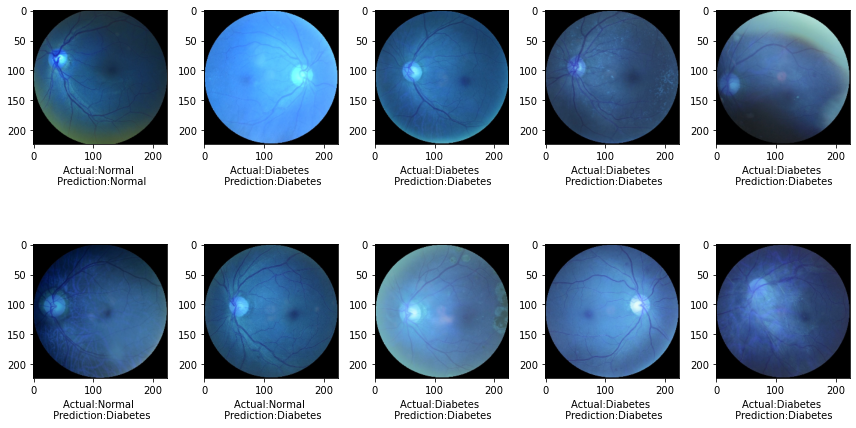

In [42]:
plt.figure(figsize=(12,7))
import random 
for i in range(10):
    
    samp = random.choice(range(len(X_test)))
    image = X_test[samp]
    category = y_test[samp][1]
    pred_category = y_pred[samp]
    
    if category == 0:
        label = "Normal"
    else:
        label = "Diabetes"

    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Diabetes"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(f"Actual:{label} \n Prediction:{pred_label}")
    
plt.tight_layout()

#### Model 3 - Resnet50 Multiclass (100 Epochs)

In [78]:
import tensorflow as tf
import tensorflow_addons as tfa
import pathlib
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

In [79]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 25
IMG_DIR = pathlib.Path('ocular_disease_fundus/preprocessed_images')
TRAIN_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/Actual Training Images'
VAL_DIR = 'ocular_disease_fundus/ODIR-5K/ODIR-5K/Actual Testing Images'

In [80]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [81]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')

Found 3340 images belonging to 7 classes.
Found 2291 images belonging to 7 classes.


In [82]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [83]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [84]:
num_classes = 7

model = Sequential()
model.add(resnet)
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense_9 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 455       
Total params: 23,723,463
Trainable params: 9,067,079
Non-trainable params: 14,656,384
__________________________________

In [85]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=4,
                                   verbose=1,
                                   min_delta=5*1e-3,min_lr = 5*1e-7,
                                   )

In [86]:
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [25]:
model.fit(train_generator,
          steps_per_epoch=np.ceil(float(3340) / float(BATCH_SIZE)),
          epochs = 100,callbacks=[reduce_lr],
          validation_steps=np.ceil(float(2291) / float(BATCH_SIZE)),
          validation_data = validation_generator)

Epoch 1/100
134/134 [==============================] - 577s 4s/step - loss: 3.1743 - accuracy: 0.2662 - f1_score: 0.1772 - val_loss: 1.8539 - val_accuracy: 0.3400 - val_f1_score: 0.2237
Epoch 2/100
134/134 [==============================] - 565s 4s/step - loss: 1.8646 - accuracy: 0.3886 - f1_score: 0.2299 - val_loss: 1.6777 - val_accuracy: 0.4317 - val_f1_score: 0.2654
Epoch 3/100
134/134 [==============================] - 564s 4s/step - loss: 1.8031 - accuracy: 0.4144 - f1_score: 0.2443 - val_loss: 1.7277 - val_accuracy: 0.4260 - val_f1_score: 0.2845
Epoch 4/100
134/134 [==============================] - 567s 4s/step - loss: 1.7363 - accuracy: 0.4392 - f1_score: 0.2848 - val_loss: 1.5346 - val_accuracy: 0.4404 - val_f1_score: 0.2735
Epoch 5/100
134/134 [==============================] - 577s 4s/step - loss: 1.6705 - accuracy: 0.4626 - f1_score: 0.2991 - val_loss: 1.5025 - val_accuracy: 0.3767 - val_f1_score: 0.2334
Epoch 6/100
134/134 [==============================] - 564s 4s/step - 

In [87]:
y_pred = model.predict_classes(validation_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

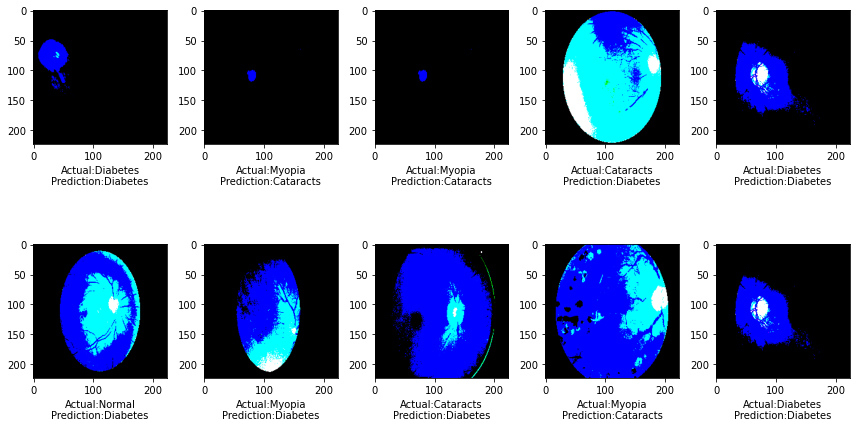

In [100]:
plt.figure(figsize=(12,7))
for i in range(10):
    samp = random.choice(range(len(validation_generator)))
    image = validation_generator[samp][0][0]
    category = y_test[samp]
    pred_category = y_pred[samp]
    if category == 0:
        label = "AMD"
    elif category == 1:
        label = "Cataracts"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Normal"
    if pred_category == 0:
        pred_label = "AMD"
    elif pred_category == 1:
        pred_label = "Cataracts"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Normal"

    plt.subplot(2,5,i+1)
    plt.imshow(image, cmap = "gray")
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()